In [6]:
## DO NOT MODIFY! 
## Import from previous notebook
import nbimporter
from p1 import cv2, np, plt, math, SimpleNamespace
from p1 import get_parameters, Gauss2D, filter_image_vec
from p2 import edge_detection_nms
from p3 import hough_transform#, peak_hough_lines

image_list, constants = get_parameters()

def peak_hough_lines(H, rho_arr, theta_arr, num_lines):
    """Returns the rhos and thetas corresponding to top local maximas in the accumulator H

    Args:
        H: np.array, (num of rhos x num of thetas), hough transform accumulator
        rho_arr: np.array, dim=num of rhos, quantized rhos
        theta_arr: np.array, dim=num of thetas, quantized thetas
        num_lines: integer, number of lines we wish to detect in the image
        
    Returns:
        peak_rho_arr: np.array, dim=num_lines, top num_lines rhos by votes in the H
        peak_theta_arr: np.array, dim=num_lines, top num_lines thetas by votes in the H
    """
    
    # compute peak_rho_arr and peak_theta_arr
    # sort H using np.argsort, pick the top num_lines lines
    peak_rho_idx, peak_theta_idx = np.unravel_index(np.argsort(H, None)[-num_lines:], H.shape) # Flatten the array to easily sort all the values then unravel (1D -> 2D) to have y_idxs and x_idxs
    peak_rho_arr   = rho_arr[peak_rho_idx]
    peak_theta_arr = theta_arr[peak_theta_idx]
    
    assert(len(peak_rho_arr) == num_lines)
    assert(len(peak_theta_arr) == num_lines)
    return peak_rho_arr, peak_theta_arr

#----------------------------------------------------------------------
# Different from visualize in p3, calls hough_accumulator_nms()
def visualize(image_name, constants):
    image_rgb = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    print("-" * 50 + "\n" + "Original Image:")
    plt.imshow(image_rgb); plt.show() # Displaying the sample image
    
    image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    image_m, image_o, image_x, image_y = edge_detection_nms(image, constants.sigma)
    
    print("-" * 50 + "\n" + "Edge Image:")
    plt.imshow(image_m, cmap="gray"); plt.show() # Displaying the sample image
    
    image_m_thres = 1.0*(image_m > constants.thres) # threshold the edge magnitude image
    print("-" * 50 + "\n" + "Thresholded Edge Image:")
    plt.imshow(image_m_thres, cmap="gray"); plt.show() # Displaying the sample image
    
    #--------------hough transform----------------
    H, rho_arr, theta_arr = hough_transform(image_m, constants.thres, constants.rho_res, constants.theta_res)
    H = hough_accumulator_nms(H) # nms on H
    peak_rho_arr, peak_theta_arr = peak_hough_lines(H, rho_arr, theta_arr, constants.num_lines)
    
    #--------------vis----------------------------
    vis_line_len = 1000 # len of line in pixels, big enough to span the image
    vis_image_rgb = np.copy(image_rgb)
    for (rho, theta) in zip(peak_rho_arr, peak_theta_arr):
        x0 = rho*np.cos(theta); y0 = rho*np.sin(theta)
        x1 = int(x0 - vis_line_len*np.sin(theta)); y1 = int(y0 + vis_line_len*np.cos(theta))
        x2 = int(x0 + vis_line_len*np.sin(theta)); y2 = int(y0 - vis_line_len*np.cos(theta)); 
        cv2.line(vis_image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    #---------------------------------------------
    print("-" * 50 + "\n" + "Edge Image:")
    plt.imshow(vis_image_rgb); plt.show() # Displaying the sample image
    
    return

### Q4.1 Non-Maximal Suppression for the Hough Accumulator (5 points)

Write a function that modifies the accumulator H suppressing the neighboring lines

```
  def hough_accumulator_nms(H):
        
        return H_prime

```

- **Input**: *$H$* is the accumulator matrix (rhos x thetas),
- **Output**: *$H\_prime$* is the suppressed accumulator matrix (rhos x thetas),

**Instructions**
- Often for every locally maximal cell in H, there will probably be its neighboring cells which also score highly. 
- We wish to avoid the selection of these neighboring cells using non maximal suppression.
- This NMS step is different than the edge magnitude NMS performed earlier. 
- Here you will consider all the 8 neighbors of the pixel, not just the pixels lying along the gradient direction.
- If for one of the neighbor, H[pixel] < H[neighbor] then set H_prime[pixel] = 0



In [5]:
def hough_accumulator_nms(H):
    """Compute Hough Transform for the image

    Args:
        image_m: np.array, HxW, edge magnitude image.
        
    Returns:
        image_m_prime: np.array, HxW, suppressed edge magnitude image.
    """
    # Set up vectorization
    H_prime = np.copy(H) 
    H_pad = np.pad(H, 1)
    neighbor_offsets = [(dy, dx) for dy in range(-1, 2) for dx in range(-1, 2) if (dy != 0 or dx != 0)]

    # With this padded H, shift around the padding and compare to the reference H matrix
    # First Example: -1, -1: we will compare H to a version of H shifted up one pixel and left one pixel. 
    #   - This will act as comparing each pixel to its neighbor up and to the left. If that upper left pixel is greater, the suppression flag is true
    suppress_masks_per_neighbor = [H_pad[dy + 1: dy + H_pad.shape[0] - 1, dx + 1 : dx + H_pad.shape[1] - 1] > H for (dy, dx) in neighbor_offsets]
    
    # Now, we will have 8 different masks, we should do a bitwise or operator in order to find everything that should be suppressed
    suppress_mask = np.logical_or.reduce(suppress_masks_per_neighbor) # 1 to suppress, 0 to keep
    H_prime[suppress_mask] = 0
    
    return H_prime

### Q4.2 Line Segments for Visualization (15 points)

Write a function that visualizes the line segments (unlike the infinite lines from the function provided) on the image 
Note, this question will not be autograded but manually graded. Please submit the visualization of all 10 images into your writeup for full credit.

```
  def visualize_line_segments(image_name, constants):
        
        return vis_image_rgb

```

- **Input**: *$image\_name$* is the image path of input image, *$constants$ are the hyperparameters*.
- **Output**: *$vis\_image\_rgb$* is the visualized image containing line segments.

**Instructions**
- For each pixel, if it belongs to an edge, for all lines passing through the pixel, try fitting a fixed length small line segment centered at the pixel and match it with the line.
- If the pixel passes this check, draw the fixed small line segment on the image.

**Grading** Manually done for all the 10 images in the data folder.

In [4]:
def visualize_line_segments(image_name, constants):
    image_rgb = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)  
    image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    image_m, image_o, image_x, image_y = edge_detection_nms(image, constants.sigma)
    vis_image_rgb = np.copy(image_rgb)
    
    #--------------hough transform----------------
    H, rho_arr, theta_arr = hough_transform(image_m, constants.thres, constants.rho_res, constants.theta_res)
    H = hough_accumulator_nms(H) # nms on H
    peak_rho_arr, peak_theta_arr = peak_hough_lines(H, rho_arr, theta_arr, constants.num_lines)
    
    edge_map = 1.0*(image_m > constants.thres) # threshold the edge magnitude image

    # visualize line segments (not infinite lines!)
    line_seg_length = 2
    cushion         = 1

    # Collect
    for (rho, theta) in zip(peak_rho_arr, peak_theta_arr):

        # 1. Sample the center pixel location using theta and rho
        x0 = rho*np.cos(theta); y0 = rho*np.sin(theta)

        # # 2. Ensure this pixel is on the edge map
        # is_edge = edge_map[y0, x0]

        # Search in both directions
        for i in range(2):
            # Always start the search at the center point
            x_curr = x0; y_curr = y0

            line_factor = 0

            # 3. Search along the infinite line in both directions until we reach the end of the image, drawing line segments as necessary
            while y_curr > line_seg_length and y_curr < edge_map.shape[0] - line_seg_length and x_curr > line_seg_length and x_curr < edge_map.shape[1] - line_seg_length:
                line_factor += line_seg_length
                # Depending on whether we are on iteration 0 or 1, go a different way to search the line
                if i == 0:
                    x_adj = x0 - line_factor*np.sin(theta); y_adj = y0 + line_factor*np.cos(theta)
                elif i == 1:
                    x_adj = x0 + line_factor*np.sin(theta); y_adj = y0 - line_factor*np.cos(theta);

                # 4. If the end points are a line, draw the line segment
                y_curr_rnd = round(y_curr)
                x_curr_rnd = round(x_curr)
                y_adj_rnd  = round(y_adj)
                x_adj_rnd  = round(x_adj)
                if np.any(edge_map[y_curr_rnd - cushion : y_curr_rnd + cushion, x_curr_rnd - cushion : x_curr_rnd + cushion]) and \
                   np.any(edge_map[y_adj_rnd  - cushion : y_adj_rnd  + cushion, x_adj_rnd  - cushion : x_adj_rnd  + cushion]):
                    cv2.line(vis_image_rgb, (int(x_curr), int(y_curr)), (int(x_adj), int(y_adj)), (0, 255, 0), 2)
            
                # Continue to move along the line in the same direction
                x_curr = x_adj
                y_curr = y_adj
    
    return image_rgb, vis_image_rgb

### Test Q4.1

--------------------------------------------------
Original Image:


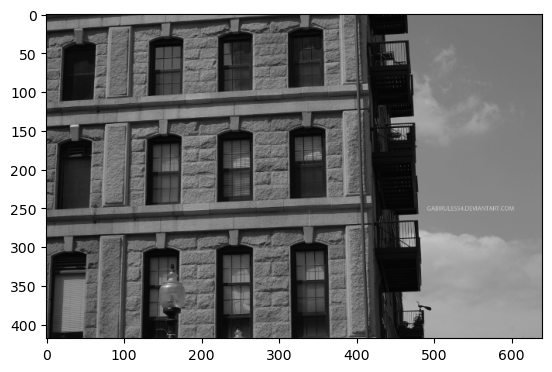

--------------------------------------------------
Edge Image:


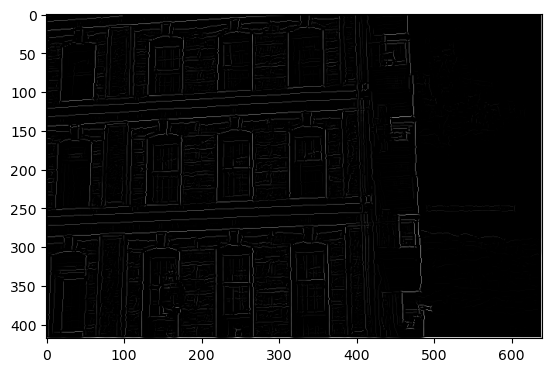

--------------------------------------------------
Thresholded Edge Image:


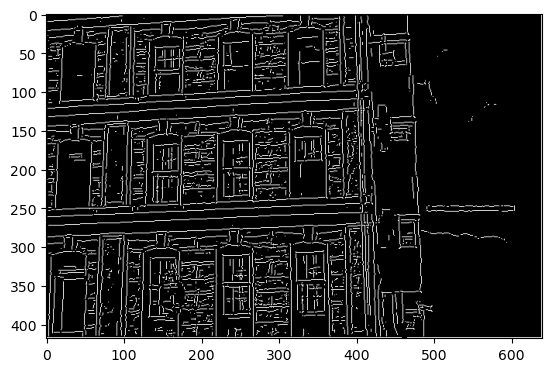

NameError: name 'hough_accumulator_nms' is not defined

In [3]:
# TOY TEST!
# H = np.random.rand(5, 5)
# H_prime = hough_accumulator_nms(H)
# print(H); print(H_prime)

# Uncomment to visualize
image_idx = 7
visualize(image_list[image_idx], constants)

### Test Q4.2

--------------------------------------------------
Edge Image:0


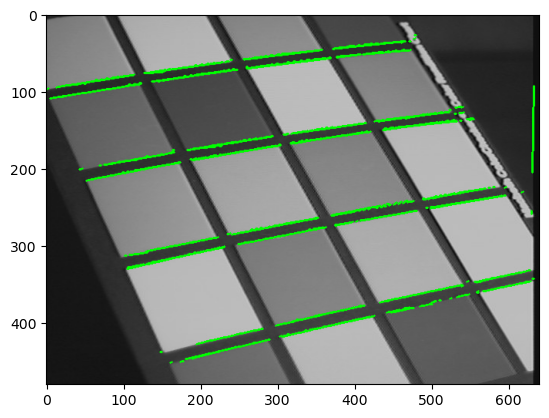

--------------------------------------------------
Edge Image:1


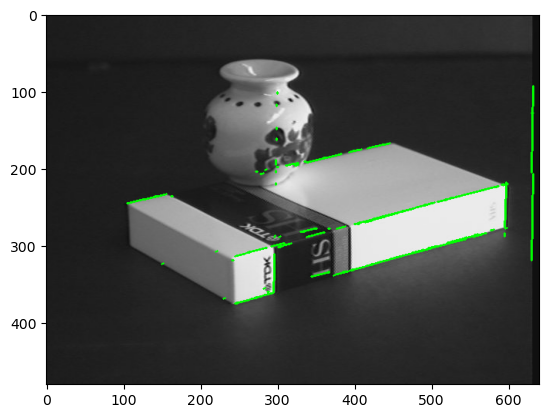

--------------------------------------------------
Edge Image:2


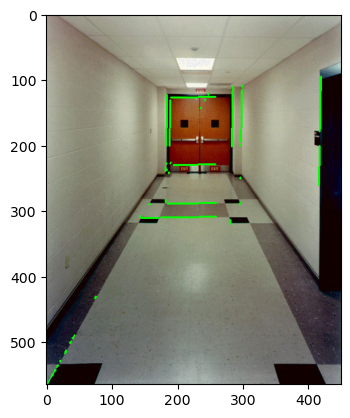

--------------------------------------------------
Edge Image:3


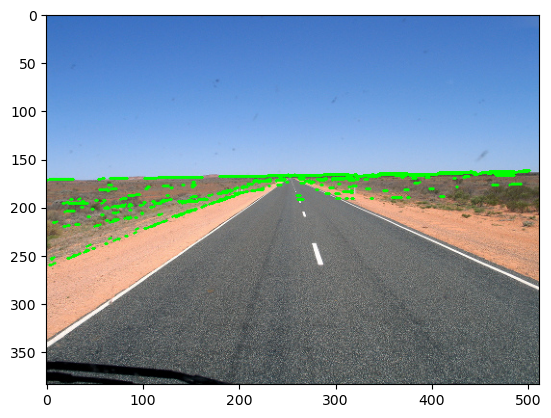

--------------------------------------------------
Edge Image:4


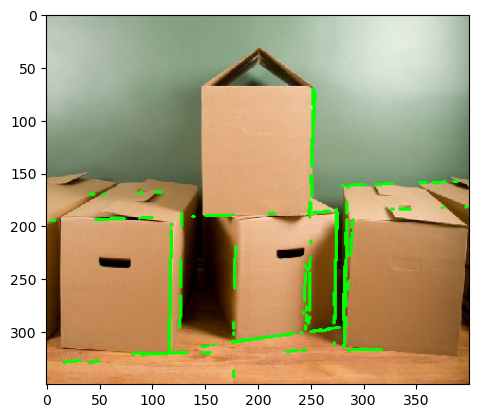

--------------------------------------------------
Edge Image:5


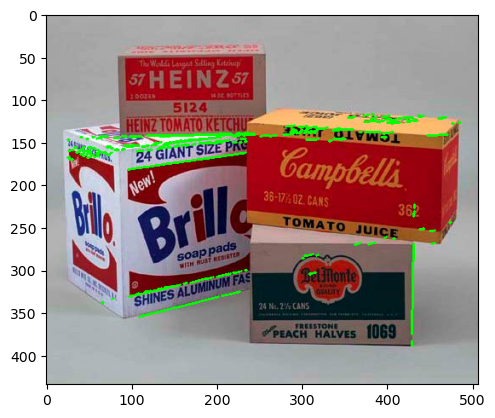

--------------------------------------------------
Edge Image:6


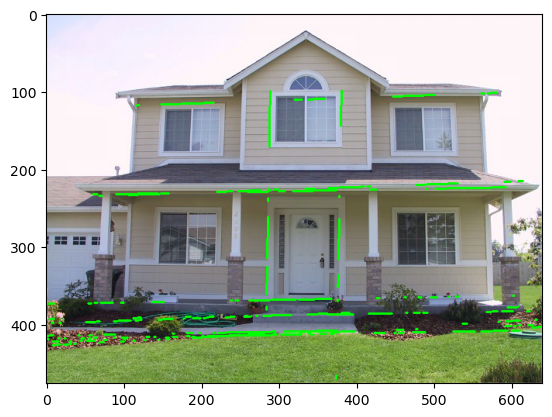

--------------------------------------------------
Edge Image:7


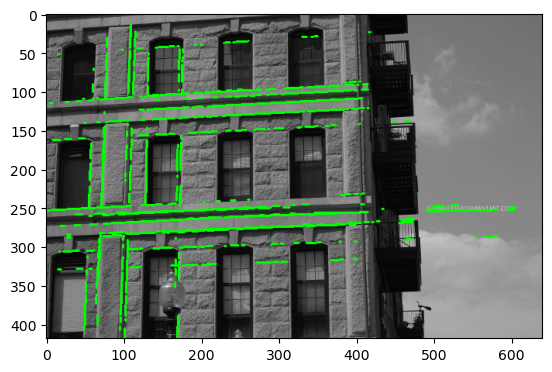

--------------------------------------------------
Edge Image:8


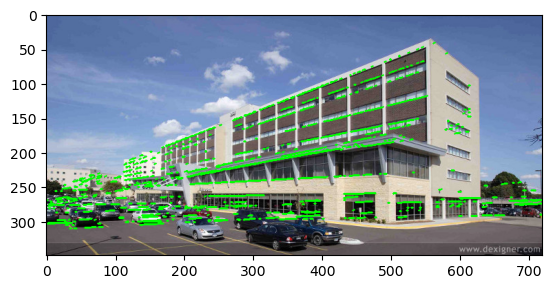

--------------------------------------------------
Edge Image:9


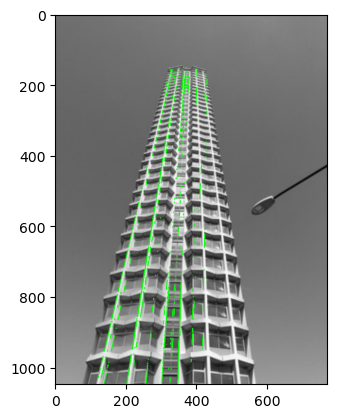

In [163]:
# YOUR CODE HERE
for image_idx in range(10):
    image_rgb, edge_image = visualize_line_segments(image_list[image_idx], constants)
    print("-" * 50 + "\n" + f"Edge Image:{image_idx}")
    plt.imshow(edge_image); plt.show() # Displaying the sample image

### Autograde Q4.1
0.5 points per test case, 10 test cases